In [2]:
import os
import glob
import nibabel as nib
import numpy as np
from nilearn import plotting
import torch
from pytorch_msssim import ms_ssim
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures
from tqdm import tqdm

__Helper Function to Create Mean Image__

In [63]:
def create_mean_image(input_directory, output_directory_path):
    file_list = glob.glob(os.path.join(input_directory, '*.nii.gz'))

    if len(file_list) == 0:
        print("No NIFTI files found in the provided directory.")
        return

    sample_image = nib.load(file_list[0])
    image_shape = sample_image.shape
    total_images = np.zeros(image_shape)

    for file in file_list:
        image = nib.load(file)

        if image.shape != image_shape:
            print(f"Image {file} has different dimensions. Skipping this file.")
            continue

        image_data = image.get_fdata()
        
        mean_val = np.mean(image_data)
        std_val = np.std(image_data)
        if std_val != 0:
            standardized_image_data = (image_data - mean_val) / std_val
        else:
            standardized_image_data = np.zeros(image_data.shape)

        total_images += standardized_image_data

    mean_image = total_images / len(file_list)
    mean_nifti = nib.Nifti1Image(mean_image, sample_image.affine)
    output_path = output_directory_path + 'ad_mean_image.nii.gz'
    mean_nifti.to_filename(output_path)

    print(f"Mean image has been saved as '{output_path}'.")
create_mean_image('/home/baris/Data/ADNI_AD_PREPROCESSED', '/home/baris/Data/')

__Visualization of mean class activation maps (CAMs) for the first convolutional layer of EfficientNet-B6__

In [36]:
def plot_nii_image(filepath, cut_coords=[22, 24, 26, 28, 30, 32, 34, 36, 40, 42], annotate_size=16, display_modes=['x', 'y', 'z']):
    img = nib.load(filepath)
    for display_mode in display_modes:
        disp = plotting.plot_img(img, cut_coords=cut_coords, draw_cross=True, 
                                 annotate=False, black_bg=True, 
                                 display_mode=display_mode, cmap='jet')
        disp.annotate(size=annotate_size, left_right=True, positions=True)

__CAMs for ADNI-only trained ADNI-AD class inference__

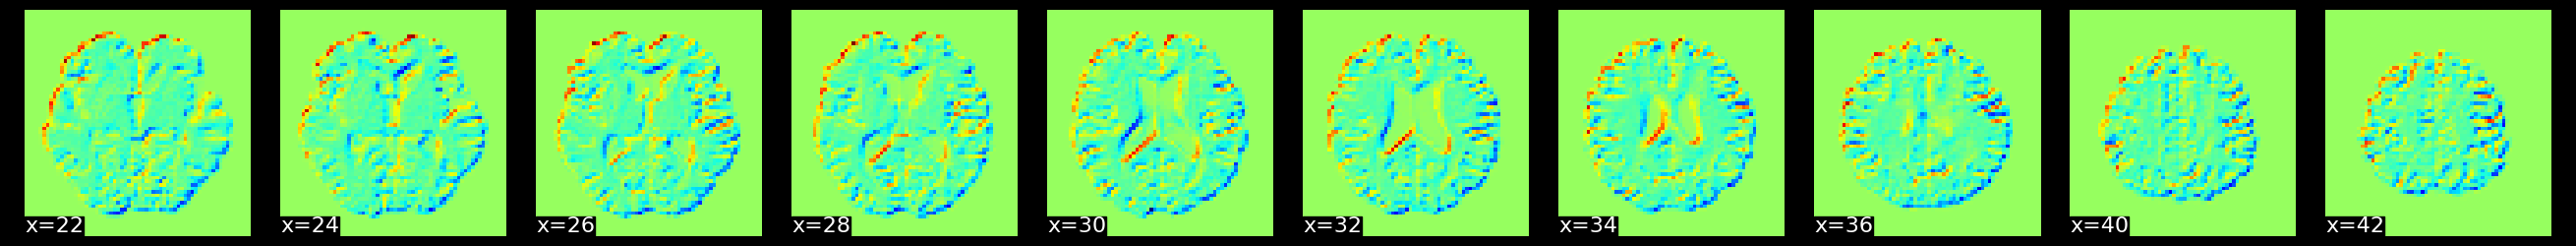

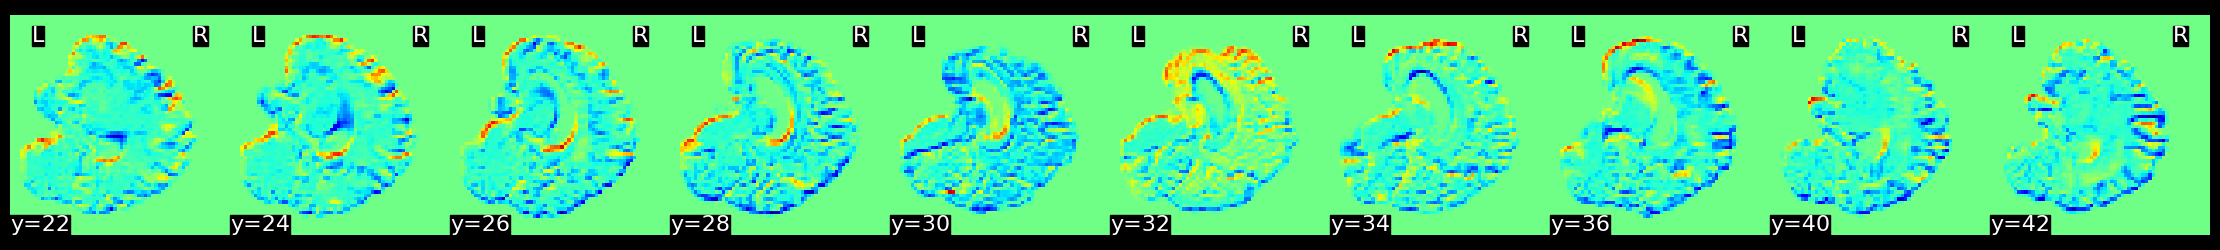

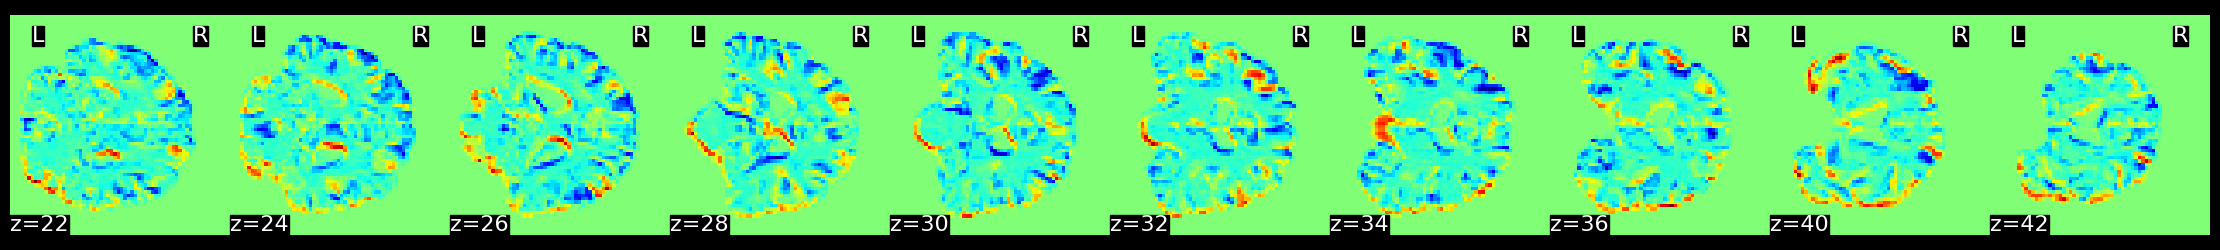

In [37]:
filepath = '/home/baris/cams/images/efficientnet_adnitrained_adni_ad_mean_cam.nii.gz' 
plot_nii_image(filepath)

__CAMs for ADNI+Synthetic trained ADNI-AD class inference__

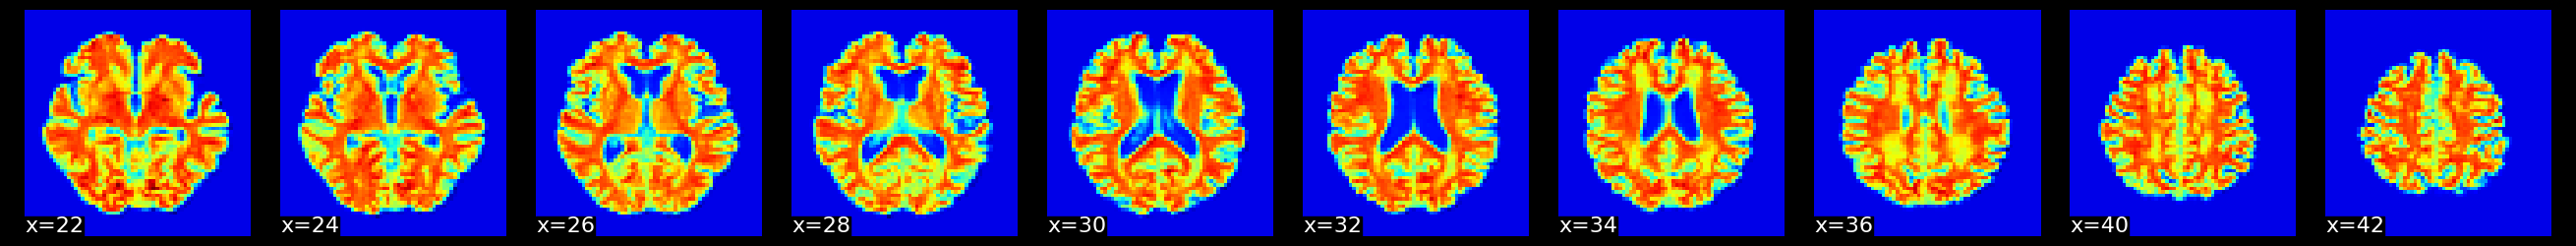

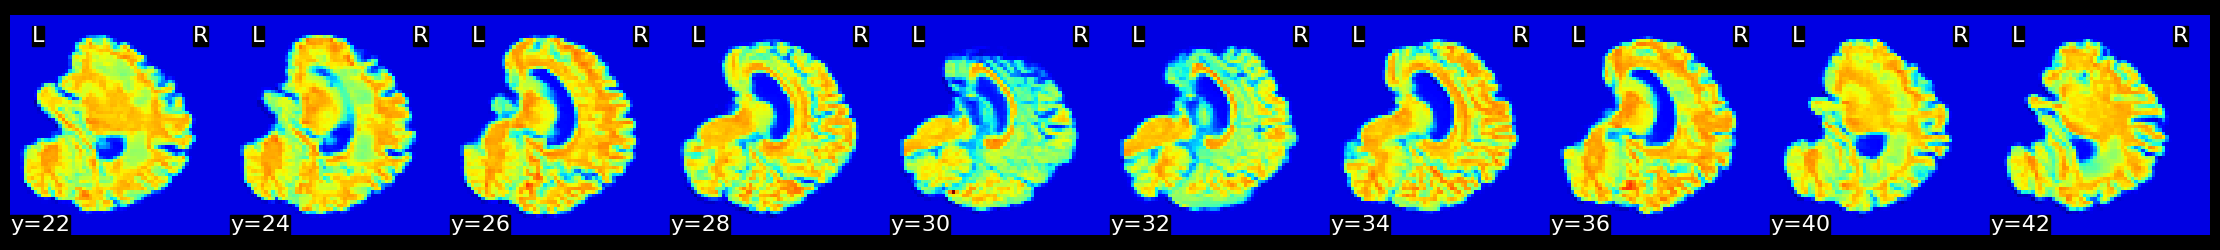

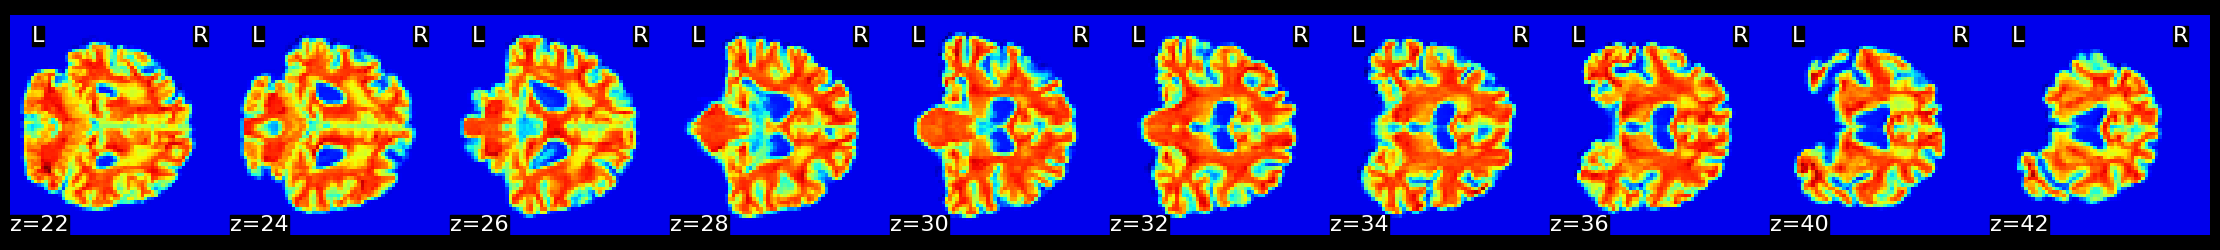

In [38]:
filepath = '/home/baris/cams/images/efficientnet_realfakeadni_ad_mean_cam.nii.gz' 
plot_nii_image(filepath)

__CAMs for ADNI-only trained OASIS-AD class inference__

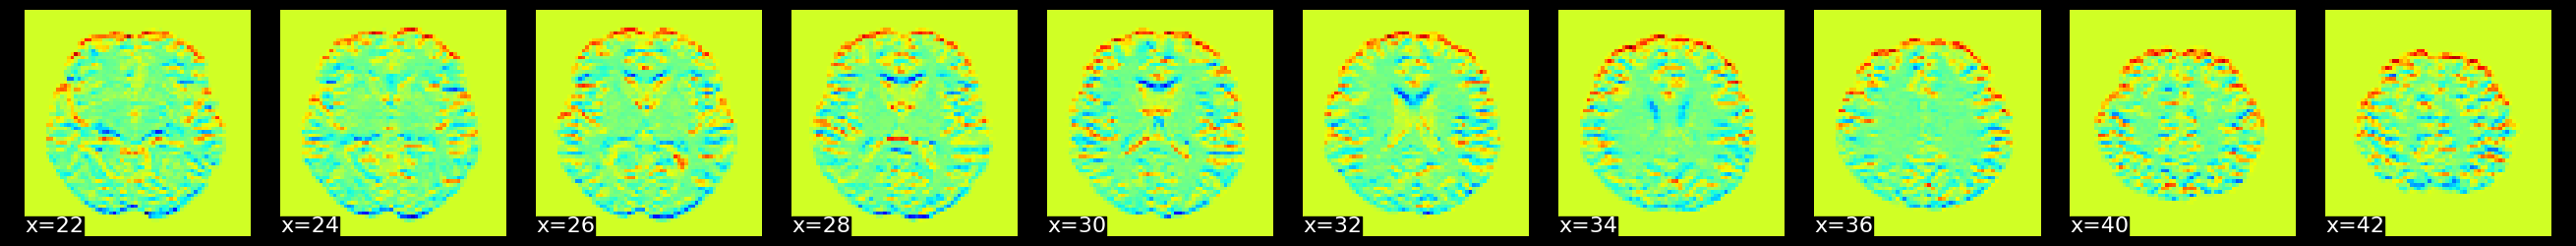

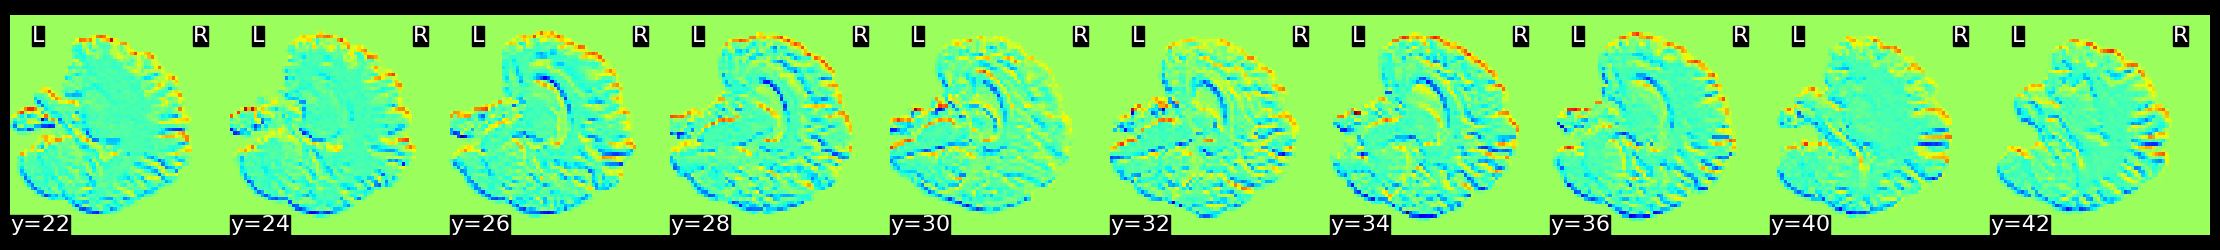

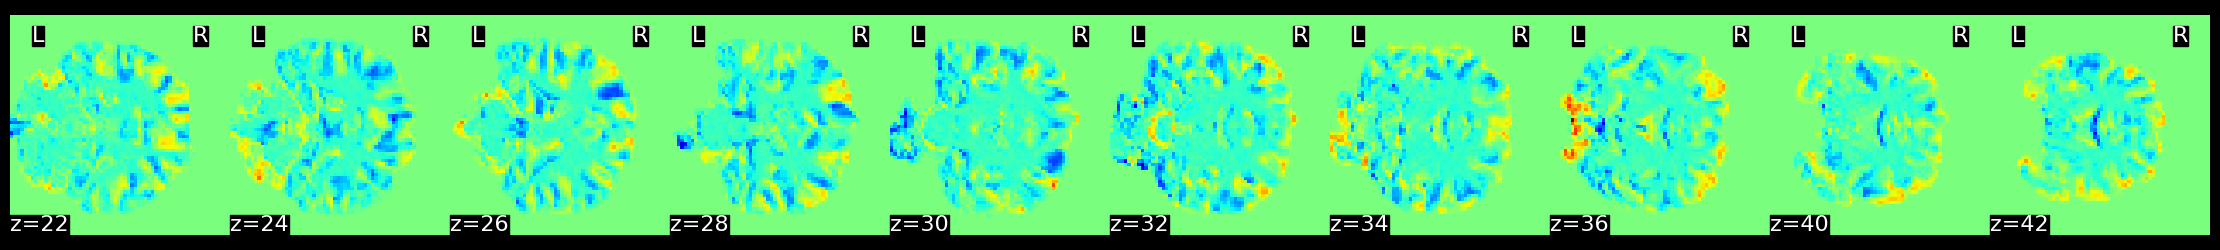

In [39]:
filepath = '/home/baris/cams/images/efficientnet_realadni_oasis_ad_meancam.nii.gz' 
plot_nii_image(filepath)

__CAMs for ADNI+Synthetic trained OASIS-AD class inference__

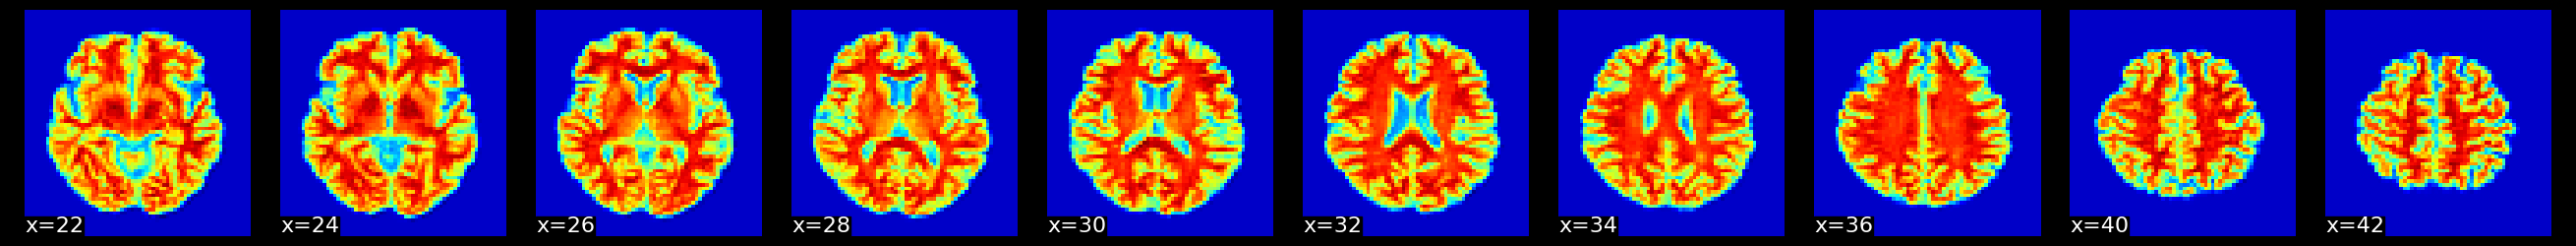

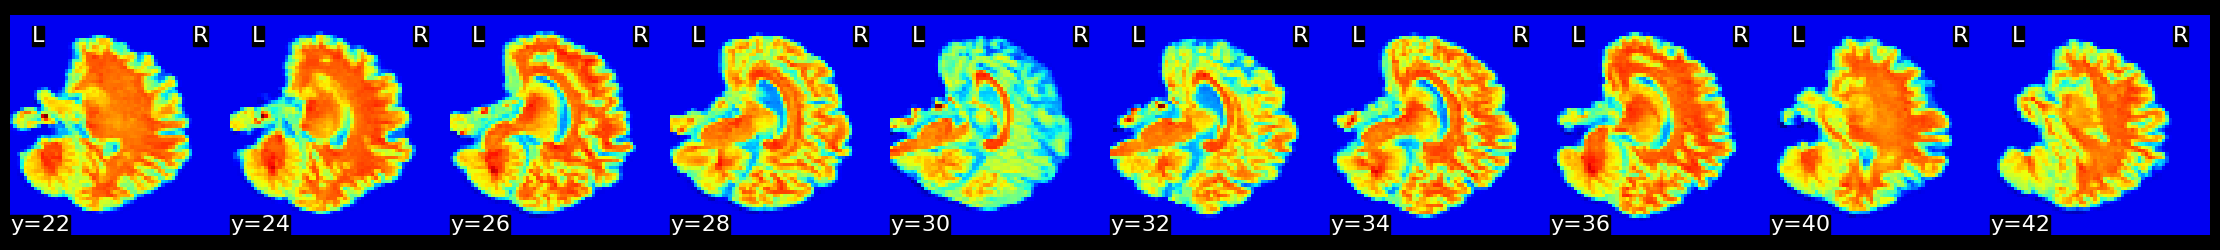

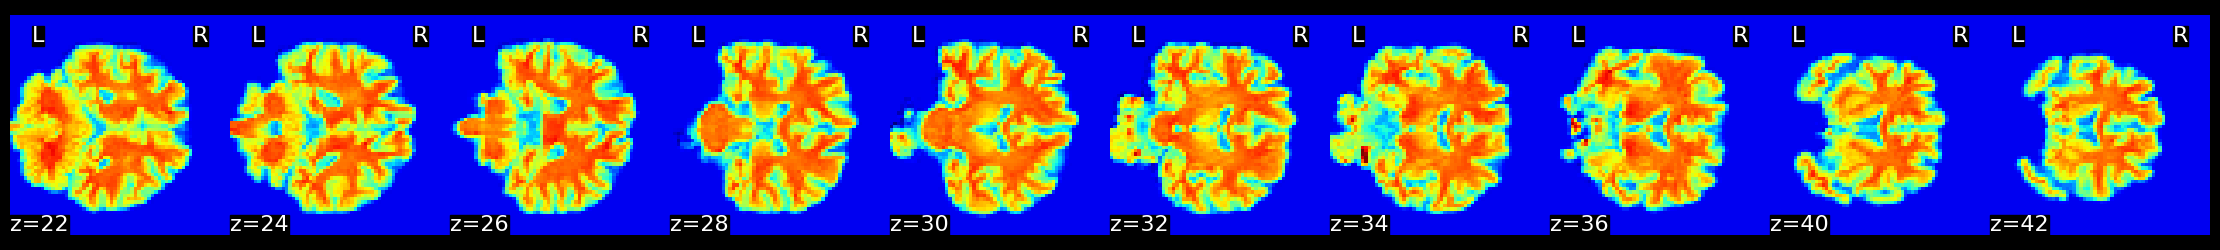

In [40]:
filepath = '/home/baris/cams/images/efficientnet_realfakeadni_oasis_ad_meancam.nii.gz'
plot_nii_image(filepath)

__CAMs for ADNI-only trained ADNI-NC class inference__

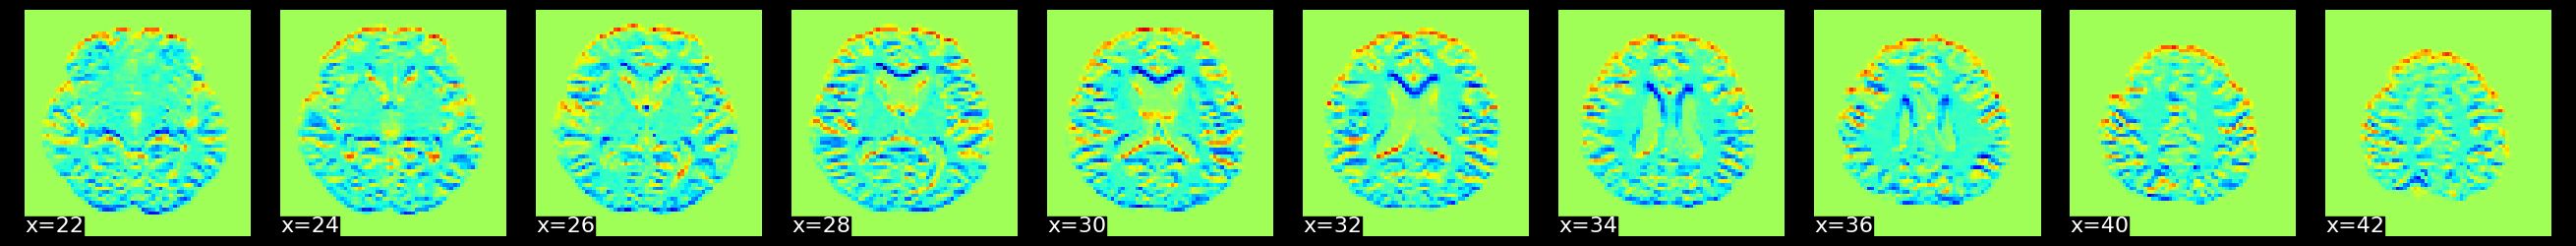

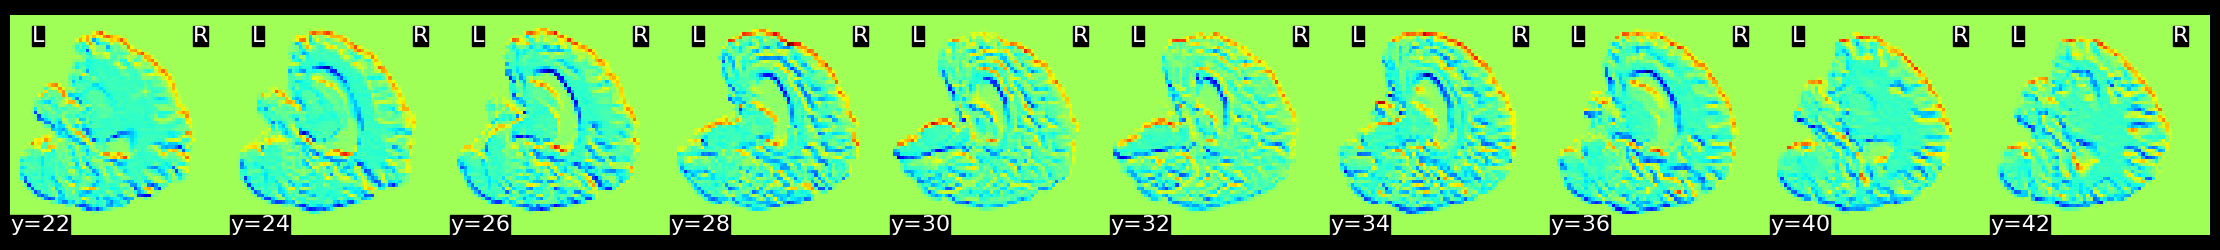

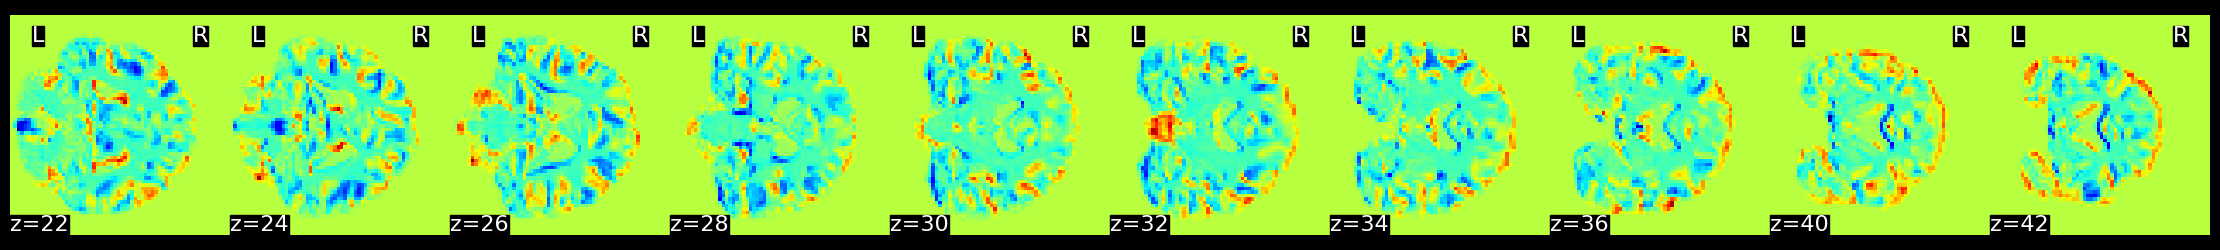

In [43]:
filepath = '/home/baris/cams/images/efficientnet_realadni_nc_mean_cam.nii.gz' 
plot_nii_image(filepath)

__CAMs for ADNI+Synthetic trained ADNI-AD class inference__

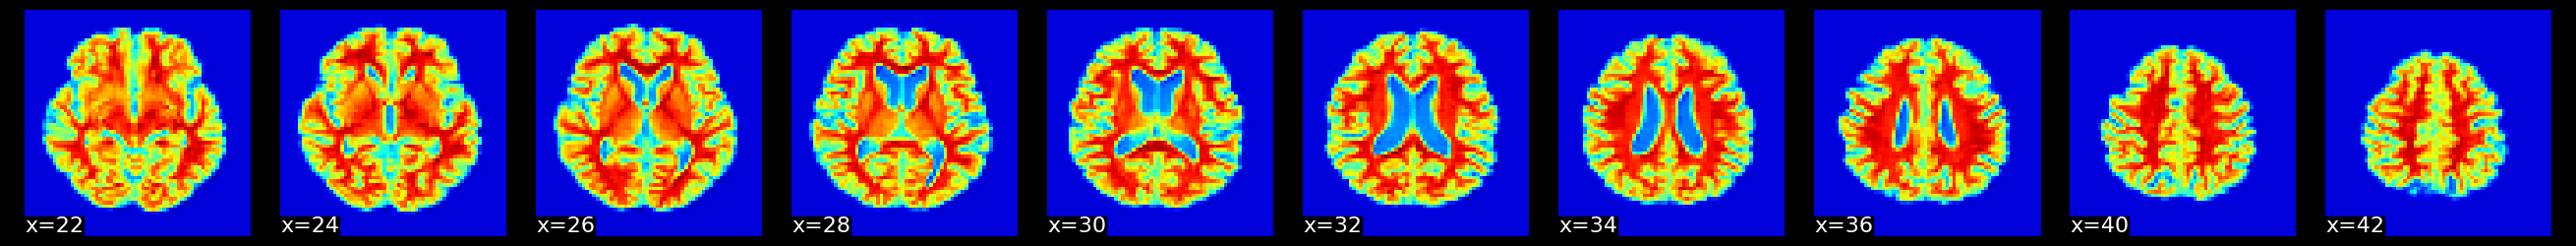

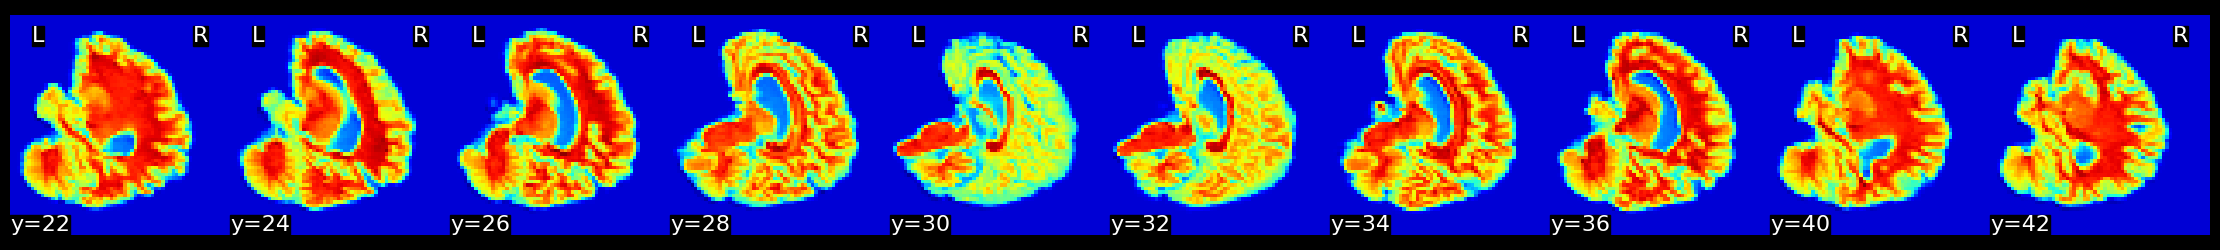

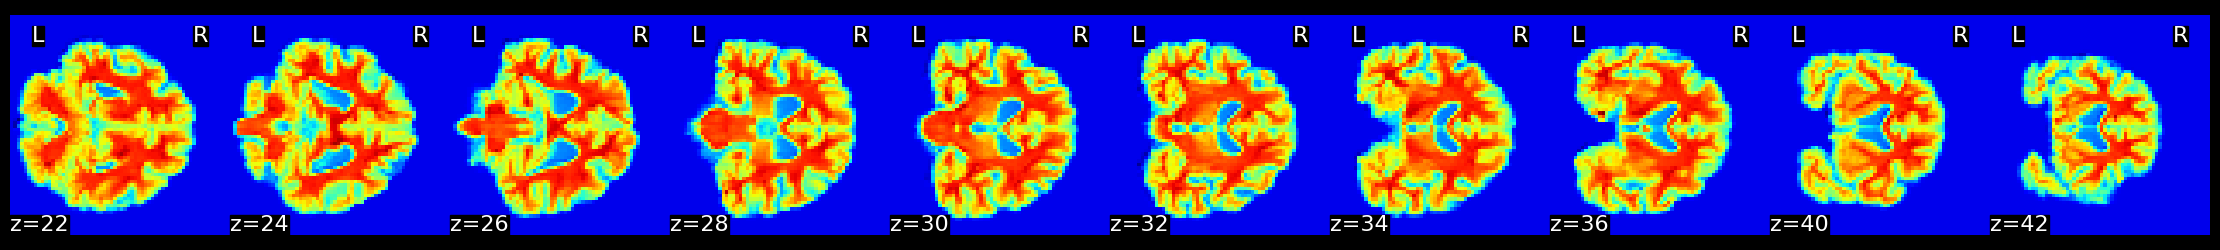

In [44]:
filepath = '/home/baris/cams/images/efficientnet_realfakeadni_nc_mean_cam.nii.gz'
plot_nii_image(filepath)

__CAMs for ADNI-only trained OASIS-NC class inference__

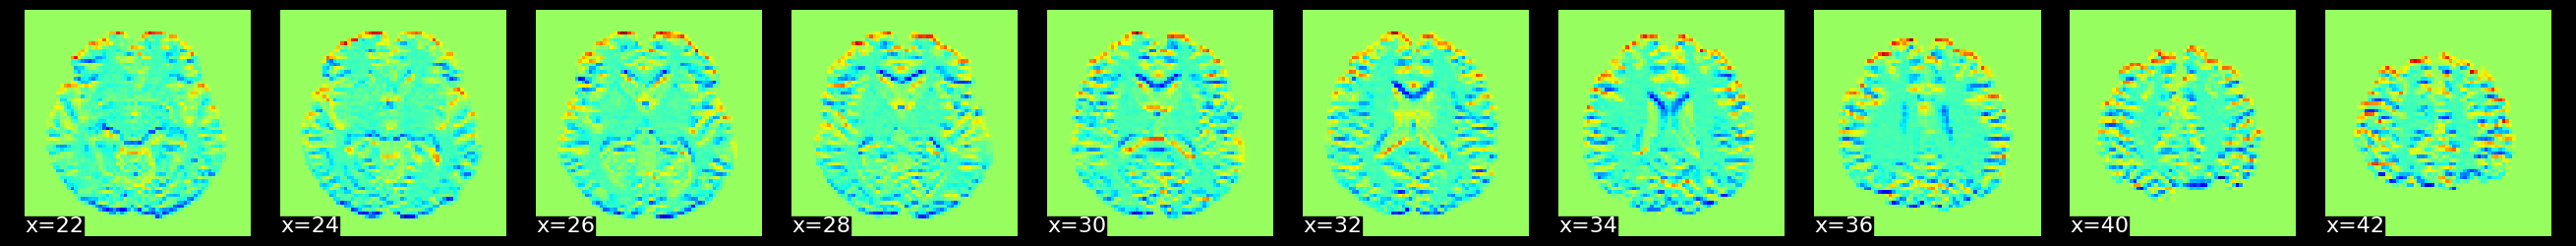

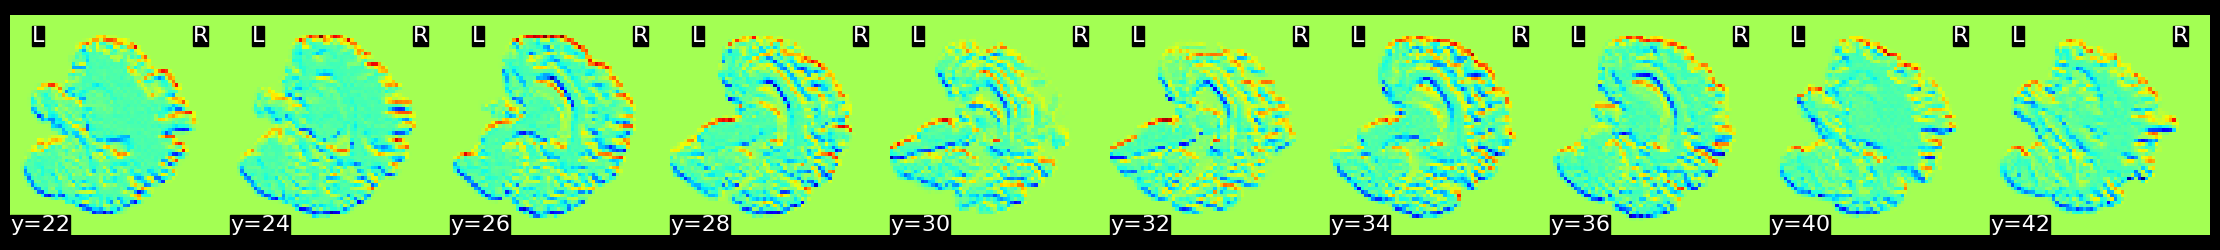

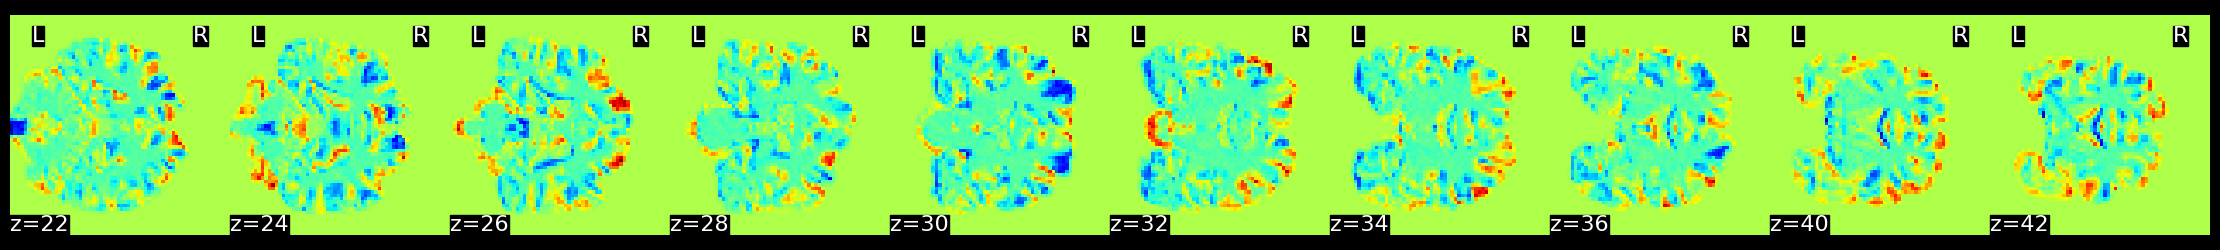

In [41]:
filepath = '/home/baris/cams/images/efficientnet_realadni_oasis_nc_meancam.nii.gz' 
plot_nii_image(filepath)

__CAMs for ADNI+Synthetic trained OASIS-NC class inference__

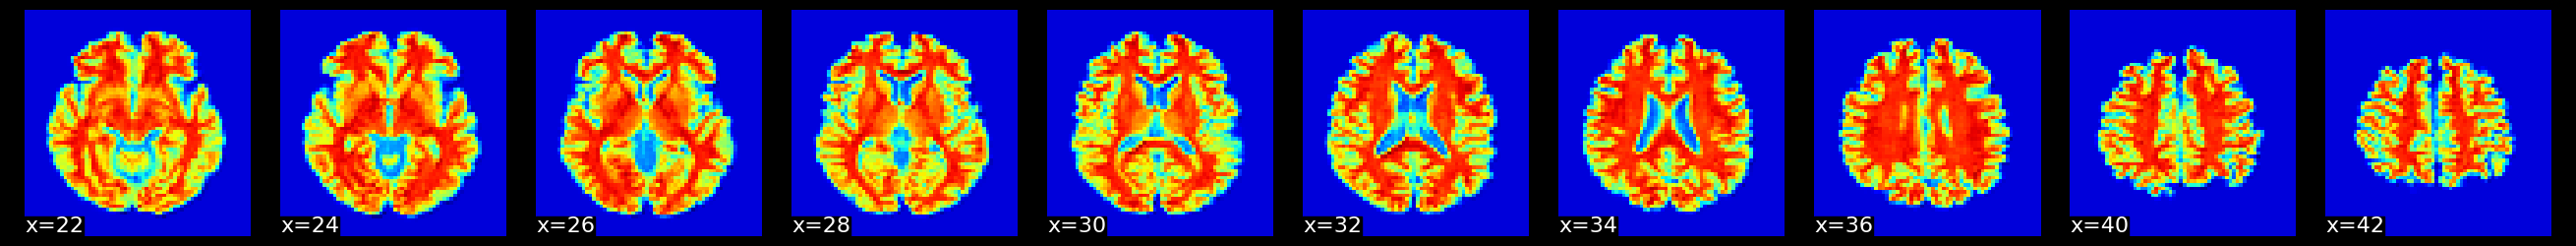

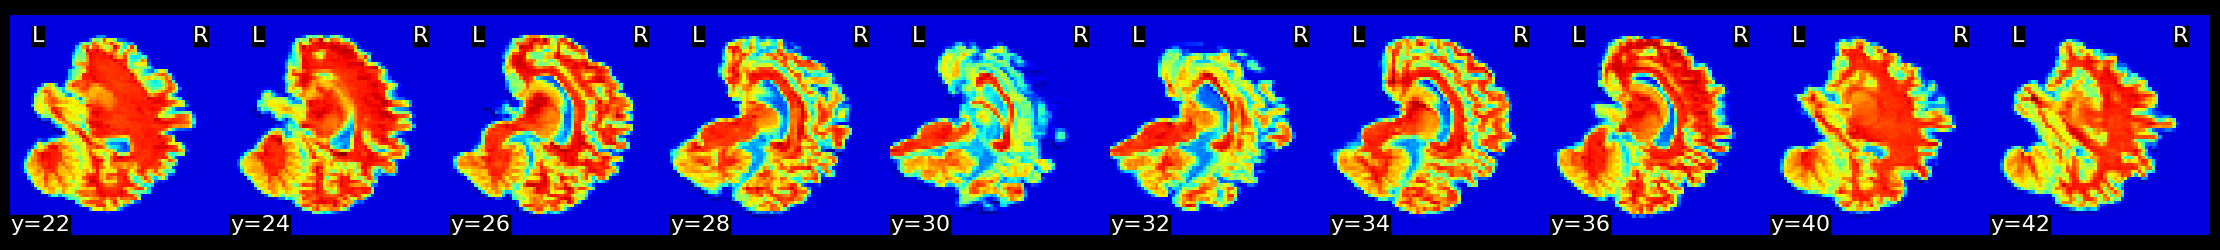

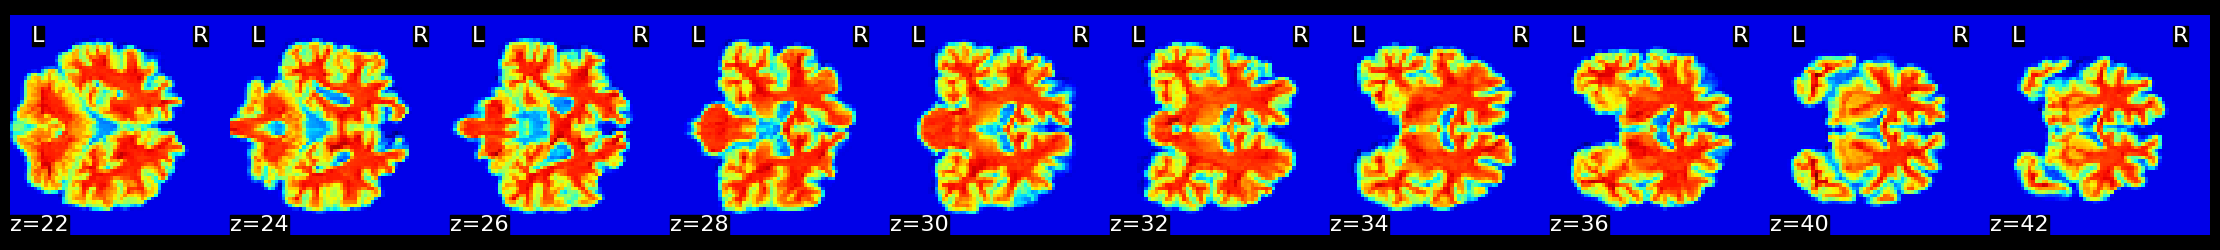

In [42]:
filepath = '/home/baris/cams/images/efficientnet_realfakeadni_oasis_nc_meancam.nii.gz' 
plot_nii_image(filepath)

__MS-SSIM Visualizations for Real and Synthetic Datasets - Compared with the Mean Image Created from the Real ADNI Dataset__

Processing NC_fakes: 100%|██████████| 22/22 [01:27<00:00,  3.96s/it]


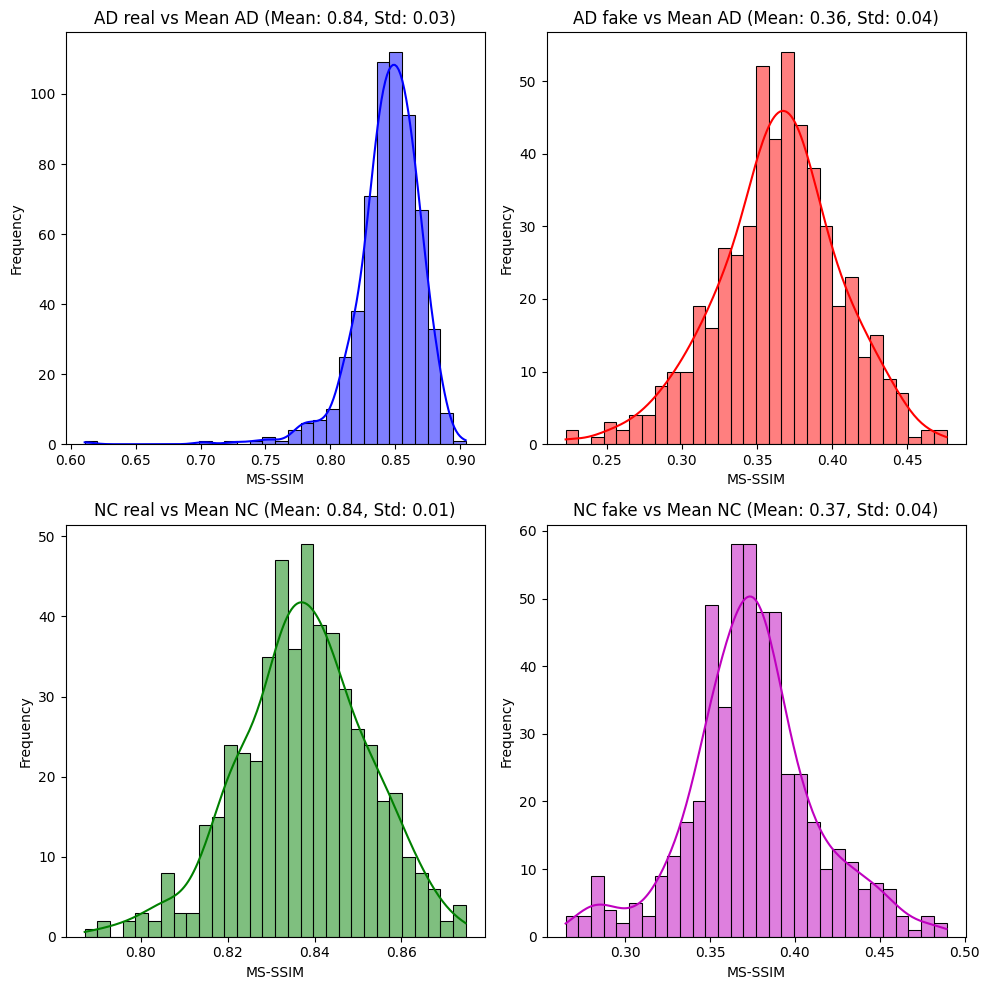

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

def load_image(file, normalize=False):
    image = nib.load(file).get_fdata()
    if normalize:
        mean = np.mean(image)
        std = np.std(image)
        image = (image - mean) / std
    return torch.from_numpy(image).float().unsqueeze(0)

ad_reference_image_path = '/home/baris/Data/ad_mean_image.nii.gz'
nc_reference_image_path = '/home/baris/Data/nc_mean_image.nii.gz'
ad_reference_image = load_image(ad_reference_image_path).to(device)
nc_reference_image = load_image(nc_reference_image_path).to(device)

paths_directories = [
    (ad_reference_image, '/home/baris/Data/ADNI_AD_PREPROCESSED', 'ADNI_AD_PREPROCESSED', True),
    (ad_reference_image, '/home/baris/Data/SOTA_OUTPUTS_preprocessed/AD_fakes', 'AD_fakes', False),
    (nc_reference_image, '/home/baris/Data/ADNI_CN_PREPROCESSED', 'ADNI_CN_PREPROCESSED', True),
    (nc_reference_image, '/home/baris/Data/SOTA_OUTPUTS_preprocessed/NC_fakes', 'NC_fakes', False)
]

results = []
batch_size = 24

for reference_tensor, directory, dataset_name, normalize in paths_directories:
    file_list = glob.glob(os.path.join(directory, '*.nii.gz'))
    ms_ssim_values = []
    for i in tqdm(range(0, len(file_list), batch_size), desc=f'Processing {dataset_name}'):
        batch_files = file_list[i:i+batch_size]
        batch = torch.stack([load_image(file, normalize=normalize).to(device) for file in batch_files])
        scores = [ms_ssim(image.unsqueeze(0), reference_tensor.unsqueeze(0), win_size=3, data_range=1, size_average=True).cpu().numpy() 
                for image in batch]
        ms_ssim_values.extend(scores)
    results.append(ms_ssim_values)

real_ad_ms_ssim_values, fake_ad_ms_ssim_values, real_nc_ms_ssim_values, fake_nc_ms_ssim_values = results
means = [np.mean(values) for values in results]
stds = [np.std(values) for values in results]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
colors = ['b', 'r', 'g', 'm']
titles = ['AD real vs Mean AD', 'AD fake vs Mean AD', 'NC real vs Mean NC', 'NC fake vs Mean NC']

for ax, values, color, title, mean, std in zip(axs.flatten(), results, colors, titles, means, stds):
    values = np.array(values) 
    sns.histplot(values, bins=30, kde=True, color=color, ax=ax)
    ax.set_title(f'{title} (Mean: {mean:.2f}, Std: {std:.2f})')
    ax.set_xlabel('MS-SSIM')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()